# Пробуем работать с RDKIT

In [1]:
import os
import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx
from collections import defaultdict
from hack_lap.utils import BondType

In [2]:
import matplotlib
# matplotlib.use('Qt5Agg')
# %matplotlib qt5
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
filename = os.path.join('..', 'data', 'train.csv')
df = pd.read_csv(filename)
df = df.loc[:, ['Smiles', 'Active']].astype({'Active': bool})
# df.drop_duplicates(subset=['Smiles'], inplace=True)
df

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False
...,...,...
5552,O=C(Oc1ccc([N+](=O)[O-])cc1)N1CCC(C(O)(c2ccc3c...,False
5553,Nc1nonc1/C(=N/O)Nc1ccc(F)c(Br)c1,False
5554,Oc1cccc2cccnc12,False
5555,OC(c1ccc(-c2ccc(CN3CCN(Cc4ccncc4)CC3)cc2)c(F)c...,False


In [4]:
df['Active'].value_counts()

False    5351
True      206
Name: Active, dtype: int64

In [27]:
count_atoms = defaultdict(list)
for s in df['Smiles'].tolist():
    mol = Chem.MolFromSmiles(s)
    na = {a.GetSymbol() for a in mol.GetAtoms()}
    for nai in na:
        count_atoms[nai] += [s]
sorted({k: len(v) for k, v in count_atoms.items()}.items(), key=lambda x: -x[1])

[('C', 5552),
 ('O', 5052),
 ('N', 4759),
 ('S', 1322),
 ('Cl', 1199),
 ('F', 854),
 ('Br', 172),
 ('P', 107),
 ('Na', 80),
 ('I', 76),
 ('B', 13),
 ('Ca', 9),
 ('K', 8),
 ('Zn', 5),
 ('Se', 3),
 ('As', 2),
 ('Si', 2),
 ('Mg', 2),
 ('Li', 2),
 ('H', 1),
 ('Sr', 1),
 ('Ag', 1),
 ('Al', 1)]

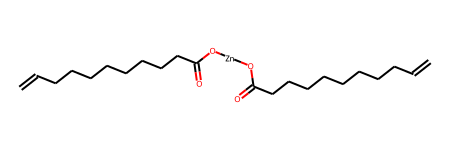

In [21]:
name = 'Zn'
s = count_atoms[name][0]
mol = Chem.MolFromSmiles(s)
mol

CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl
False


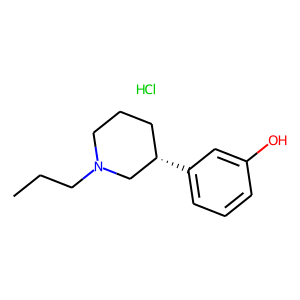

In [22]:
i = 1
s = df.loc[i, 'Smiles']
print(s)
print(df.loc[i, 'Active'])

mol = Chem.MolFromSmiles(s)
Draw.MolToImage(mol)

In [26]:
used_atoms = set()
for s in df['Smiles'].tolist():
    mol = Chem.MolFromSmiles(s)
    used_atoms.update([a.GetAtomicNum() for a in mol.GetAtoms()])
print(sorted(used_atoms))

[1, 3, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 30, 33, 34, 35, 38, 47, 53]


In [6]:
nodes = [(i, {'id': a.GetAtomicNum(), 'symbol': str(a.GetSymbol())}) for i, a in enumerate(mol.GetAtoms())]
edges = [(b.GetBeginAtomIdx(), b.GetEndAtomIdx(), {'bond_type': str(b.GetBondType())}) for b in mol.GetBonds()]
nodes

[(0, {'id': 6, 'symbol': 'C'}),
 (1, {'id': 6, 'symbol': 'C'}),
 (2, {'id': 6, 'symbol': 'C'}),
 (3, {'id': 7, 'symbol': 'N'}),
 (4, {'id': 6, 'symbol': 'C'}),
 (5, {'id': 6, 'symbol': 'C'}),
 (6, {'id': 6, 'symbol': 'C'}),
 (7, {'id': 6, 'symbol': 'C'}),
 (8, {'id': 6, 'symbol': 'C'}),
 (9, {'id': 6, 'symbol': 'C'}),
 (10, {'id': 6, 'symbol': 'C'}),
 (11, {'id': 6, 'symbol': 'C'}),
 (12, {'id': 6, 'symbol': 'C'}),
 (13, {'id': 8, 'symbol': 'O'}),
 (14, {'id': 6, 'symbol': 'C'}),
 (15, {'id': 6, 'symbol': 'C'}),
 (16, {'id': 17, 'symbol': 'Cl'})]

In [7]:
edges

[(0, 1, {'bond_type': 'SINGLE'}),
 (1, 2, {'bond_type': 'SINGLE'}),
 (2, 3, {'bond_type': 'SINGLE'}),
 (3, 4, {'bond_type': 'SINGLE'}),
 (4, 5, {'bond_type': 'SINGLE'}),
 (5, 6, {'bond_type': 'SINGLE'}),
 (6, 7, {'bond_type': 'SINGLE'}),
 (7, 8, {'bond_type': 'SINGLE'}),
 (8, 9, {'bond_type': 'AROMATIC'}),
 (9, 10, {'bond_type': 'AROMATIC'}),
 (10, 11, {'bond_type': 'AROMATIC'}),
 (11, 12, {'bond_type': 'AROMATIC'}),
 (12, 13, {'bond_type': 'SINGLE'}),
 (12, 14, {'bond_type': 'AROMATIC'}),
 (7, 15, {'bond_type': 'SINGLE'}),
 (15, 3, {'bond_type': 'SINGLE'}),
 (14, 8, {'bond_type': 'AROMATIC'})]

In [20]:
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)

In [21]:
if not nx.is_connected(g):
    sg = [c for c in sorted(nx.connected_components(g), key=len, reverse=True)]
    sg = sg[1:]
    for si in sg:
        g.remove_nodes_from(si)
    g = nx.convert_node_labels_to_integers(g)

In [38]:
[g.nodes[i]['id'] for i in g]

[6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6]

In [54]:
edges_ = {(i, j, g.edges[i, j]['bond_type']) for i, j in g.edges}
edges_.update({(j, i, g.edges[i, j]['bond_type']) for i, j in g.edges})
edges_ = sorted(list(edges_), key=lambda x: x[:-1])
edges_attr = [v[-1] for v in edges_]
edges_ = [v[:-1] for v in edges_]
edges_attr, edges_

(['SINGLE',
  'SINGLE',
  'SINGLE',
  'SINGLE',
  'SINGLE',
  'SINGLE',
  'SINGLE',
  'SINGLE',
  'SINGLE',
  'SINGLE',
  'SINGLE',
  'SINGLE',
  'SINGLE',
  'SINGLE',
  'SINGLE',
  'SINGLE',
  'SINGLE',
  'SINGLE',
  'AROMATIC',
  'AROMATIC',
  'AROMATIC',
  'AROMATIC',
  'AROMATIC',
  'AROMATIC',
  'AROMATIC',
  'AROMATIC',
  'AROMATIC',
  'SINGLE',
  'AROMATIC',
  'SINGLE',
  'AROMATIC',
  'AROMATIC',
  'SINGLE',
  'SINGLE'],
 [(0, 1),
  (1, 0),
  (1, 2),
  (2, 1),
  (2, 3),
  (3, 2),
  (3, 4),
  (3, 15),
  (4, 3),
  (4, 5),
  (5, 4),
  (5, 6),
  (6, 5),
  (6, 7),
  (7, 6),
  (7, 8),
  (7, 15),
  (8, 7),
  (8, 9),
  (8, 14),
  (9, 8),
  (9, 10),
  (10, 9),
  (10, 11),
  (11, 10),
  (11, 12),
  (12, 11),
  (12, 13),
  (12, 14),
  (13, 12),
  (14, 8),
  (14, 12),
  (15, 3),
  (15, 7)])

In [24]:
for ij in g.edges:
    print(ij)

(0, 1)
(1, 2)
(2, 3)
(3, 4)
(3, 15)
(4, 5)
(5, 6)
(6, 7)
(7, 8)
(7, 15)
(8, 9)
(8, 14)
(9, 10)
(10, 11)
(11, 12)
(12, 13)
(12, 14)


In [19]:
g.edges[ij]

{'bond_type': 'AROMATIC'}

In [80]:
ij

(12, 14)

In [23]:
for a in mol.GetAtoms():
    print(a.GetSymbol(), a.GetAtomicNum())

C 6
C 6
C 6
N 7
C 6
C 6
C 6
C 6
C 6
C 6
C 6
C 6
C 6
O 8
C 6
C 6
Cl 17


In [22]:
dir(a)

['ClearProp',
 'DescribeQuery',
 'GetAtomMapNum',
 'GetAtomicNum',
 'GetBonds',
 'GetBoolProp',
 'GetChiralTag',
 'GetDegree',
 'GetDoubleProp',
 'GetExplicitBitVectProp',
 'GetExplicitValence',
 'GetFormalCharge',
 'GetHybridization',
 'GetIdx',
 'GetImplicitValence',
 'GetIntProp',
 'GetIsAromatic',
 'GetIsotope',
 'GetMass',
 'GetMonomerInfo',
 'GetNeighbors',
 'GetNoImplicit',
 'GetNumExplicitHs',
 'GetNumImplicitHs',
 'GetNumRadicalElectrons',
 'GetOwningMol',
 'GetPDBResidueInfo',
 'GetProp',
 'GetPropNames',
 'GetPropsAsDict',
 'GetSmarts',
 'GetSymbol',
 'GetTotalDegree',
 'GetTotalNumHs',
 'GetTotalValence',
 'GetUnsignedProp',
 'HasOwningMol',
 'HasProp',
 'HasQuery',
 'InvertChirality',
 'IsInRing',
 'IsInRingSize',
 'Match',
 'NeedsUpdatePropertyCache',
 'SetAtomMapNum',
 'SetAtomicNum',
 'SetBoolProp',
 'SetChiralTag',
 'SetDoubleProp',
 'SetExplicitBitVectProp',
 'SetFormalCharge',
 'SetHybridization',
 'SetIntProp',
 'SetIsAromatic',
 'SetIsotope',
 'SetMonomerInfo',
 'S

In [18]:
for b in mol.GetBonds():
    print(b.GetBeginAtomIdx(), b.GetEndAtomIdx(), b.GetBondType())

0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
3 4 SINGLE
4 5 SINGLE
5 6 SINGLE
6 7 SINGLE
7 8 SINGLE
8 9 AROMATIC
9 10 AROMATIC
10 11 AROMATIC
11 12 AROMATIC
12 13 SINGLE
12 14 AROMATIC
7 15 SINGLE
15 3 SINGLE
14 8 AROMATIC


In [19]:
BondType[str(b.GetBondType())], BondType(4)

(<BondType.AROMATIC: 4>, <BondType.AROMATIC: 4>)